## Azhar Rizki Zulma

Dataset: https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries

**Model Using StartDate & Value (kWh) colum**

### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.backend import clear_session

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Read Data

In [2]:
df = pd.read_csv('/power_usage_2016_to_2020.csv')
df

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [4]:
df['date']=pd.to_datetime(df['StartDate'])
df.head()

,StartDate,Value (kWh),day_of_week,notes,date
0,2016-01-06 00:00:00,1.057,2,weekday,2016-01-06 00:00:00
1,2016-01-06 01:00:00,1.171,2,weekday,2016-01-06 01:00:00
2,2016-01-06 02:00:00,0.560,2,weekday,2016-01-06 02:00:00
3,2016-01-06 03:00:00,0.828,2,weekday,2016-01-06 03:00:00
4,2016-01-06 04:00:00,0.932,2,weekday,2016-01-06 04:00:00


Create new dataframe with only 2 colum (date & value)

In [5]:
energy=df[['date','Value (kWh)']].copy()
energy['val'] = energy['Value (kWh)']
energy = energy.drop('Value (kWh)', axis=1)
energy.set_index('date', inplace= True)
energy.head()

,val
date,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


### Timeseries Plot

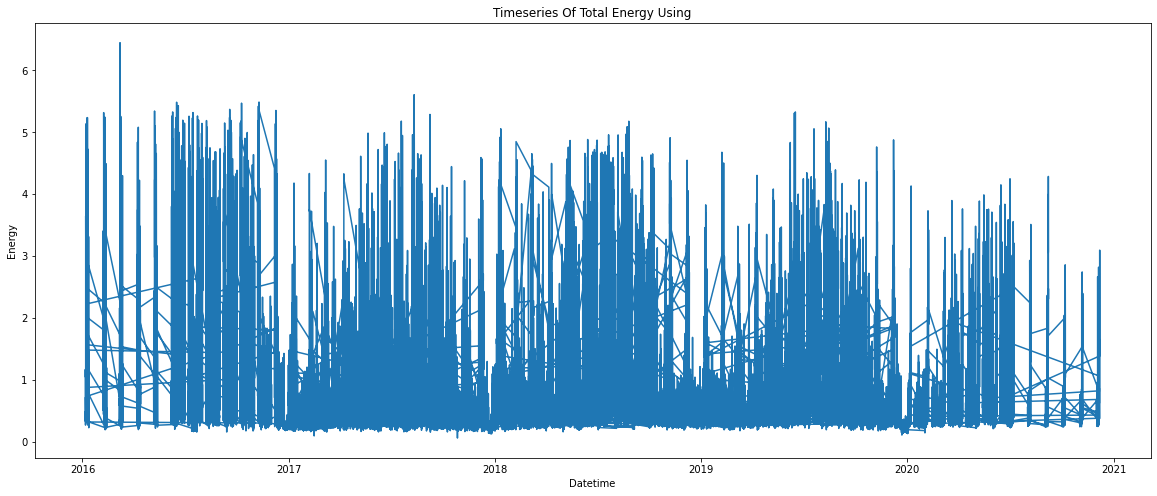

In [6]:
plt.figure(figsize=(20,8))
plt.plot(energy)
plt.title('Timeseries Of Total Energy Using')
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.show()

### Modelling

In [7]:
date = df['date'].values
val = energy['val'].values

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(val, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

28761 7191


In [10]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

**Min & Max Value**

In [12]:
min = energy['val'].min()
print('Min Value : ')
print(min)

max = energy['val'].max()
print('Max value : ' )
print(max)

Min Value : 
0.064
Max value : 
6.4460000000000015


In [13]:
x = (max - min) * (10/100)
print(x)

0.6382000000000002


In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae')< x) and (logs.get('val_mae')< x)):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [15]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train, epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
288/288 [==============================] - 37s 91ms/step - loss: 9.3977 - mae: 9.8754 - val_loss: 3.6017 - val_mae: 4.0677
Epoch 2/500
288/288 [==============================] - 25s 81ms/step - loss: 5.1340 - mae: 5.5957 - val_loss: 1.9249 - val_mae: 2.3429
Epoch 3/500
288/288 [==============================] - 17s 53ms/step - loss: 3.3024 - mae: 3.7371 - val_loss: 1.2753 - val_mae: 1.6744
Epoch 4/500
288/288 [==============================] - 15s 50ms/step - loss: 2.4126 - mae: 2.8386 - val_loss: 1.0293 - val_mae: 1.4214
Epoch 5/500
288/288 [==============================] - 15s 49ms/step - loss: 1.9548 - mae: 2.3786 - val_loss: 0.9195 - val_mae: 1.3086
Epoch 6/500
288/288 [==============================] - 15s 48ms/step - loss: 1.6865 - mae: 2.1087 - val_loss: 0.8472 - val_mae: 1.2338
Epoch 7/500
288/288 [==============================] - 16s 51ms/step - loss: 1.4924 - mae: 1.9074 - val_loss: 0.7609 - val_mae: 1.1307
Epoch 8/500
288/288 [==============================] - 

### Plot Loss & Mae

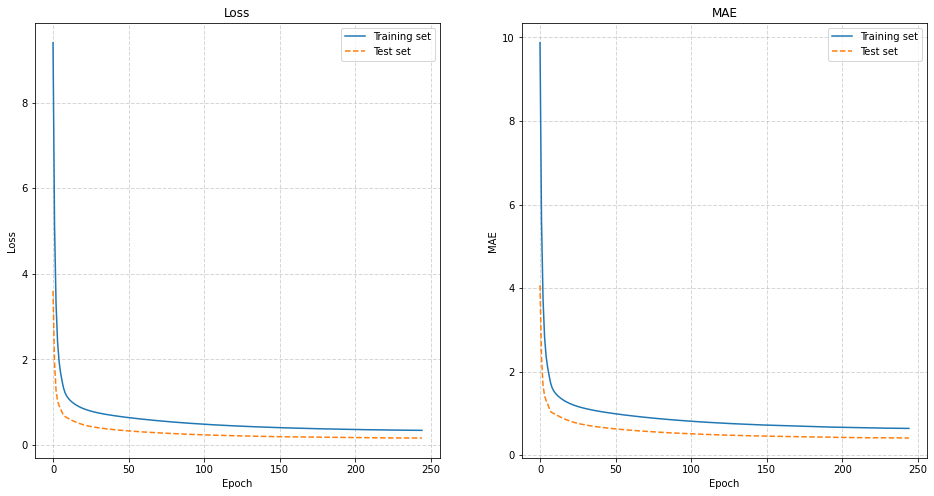

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(mae, label='Training set')
plt.plot(val_mae, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()